In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from poker_utils.constants import HANDS_DICT
from poker_utils.model import (analyze_embeddings, 
                               save_model_and_embeddings, 
                               prob_embeddings, evaluate_hand_hand_equity)


In [2]:
base_data = pd.read_csv("data/raw/base_hand_data.csv").set_index("hand")
blocker_data = pd.read_csv("data/raw/preflop_block_data.csv").set_index('hand')
ev_data = pd.read_csv('data/raw/ev_pca_data.csv').set_index('hand').filter(regex="play")
equity_data = pd.read_csv("data/processed/equity_totals.csv").set_index("hand")
equity_matrix = pd.read_csv("data/processed/equity_matrix.csv").set_index("hand")

In [3]:
full_data = pd.concat([base_data, blocker_data, equity_data, ev_data], axis=1).reset_index()

In [4]:
cols = [
    'suited', 'connectedness', 'pair', 'high_card', 'low_card',
    'rank_diff', 'ace', 'broadway', 'low_pair', 'medium_pair',
    'high_pair', 'broadway_score', 'suited_broadway',
    'suited_broadway_score', 'connector', 'one_gap', 'two_gap',
    'suited_connector', 'suited_one_gap', 'suited_two_gap',
    'connectedness_score', 'rank_diff_score', 'high_card_score',
    'low_card_score', 'suited_connected_score',
       
    'block_aa', 'block_kk', 'block_qq', 'block_ak', 'block_aq',
    'prem_blocker_score', 'prem_blocker_score_norm', 'block_aa_score',
    'block_kk_score',
       
    'tot_win_perc', 'high_card_win_perc',
    'one_pair_win_perc', 'two_pair_win_perc', 'three_of_a_kind_win_perc',
    'straight_win_perc', 'flush_win_perc', 'full_house_win_perc',
    'four_of_a_kind_win_perc', 'straight_flush_win_perc',
    'straight_win_potential', 'flush_win_potential', 'value_win_potential',
    'highcard_win_potential',
       
    'BB_play10', 'BB_play2', 'BB_play3', 'BB_play4', 'BB_play5', 'BB_play6',
    'BB_play7', 'BB_play8', 'BB_play9', 'D_play10', 'D_play3', 'D_play4',
    'D_play5', 'D_play6', 'D_play7', 'D_play8', 'D_play9', 'SB_play10',
    'SB_play2', 'SB_play3', 'SB_play4', 'SB_play5', 'SB_play6', 'SB_play7',
    'SB_play8', 'SB_play9', 'pos3_play10', 'pos3_play4', 'pos3_play5',
    'pos3_play6', 'pos3_play7', 'pos3_play8', 'pos3_play9', 'pos4_play10',
    'pos4_play5', 'pos4_play6', 'pos4_play7', 'pos4_play8', 'pos4_play9',
    'pos5_play10', 'pos5_play6', 'pos5_play7', 'pos5_play8', 'pos5_play9',
    'pos6_play10', 'pos6_play7', 'pos6_play8', 'pos6_play9', 'pos7_play10',
    'pos7_play8', 'pos7_play9', 'pos8_play10', 'pos8_play9', 'pos9_play10'
]

In [5]:
model_data = np.concat([full_data[cols].to_numpy(), equity_matrix.to_numpy()], axis=1)

In [8]:
scalar = StandardScaler()
model_data_scaled = scalar.fit_transform(model_data)

In [10]:
class PreFlopVAE(nn.Module):
    def __init__(self, input_size=271, embedding_dim=16):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64)
        )
        
        self.mean_fc = nn.Linear(64, embedding_dim)
        self.logvar_fc = nn.Linear(64, embedding_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 128),
            nn.LeakyReLU(),
            nn.Linear(128, input_size)
        )
        
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + eps * std
        return z
        
    def forward(self, x):
        h = self.encoder(x)
        mean = self.mean_fc(h)
        logvar = self.logvar_fc(h)
        z = self.reparameterize(mean, logvar)
        recon = self.decoder(z)
        return recon, mean, logvar
    

In [11]:
def loss_func(recon_x, x, mean, logvar, beta=0.5):
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')
    kl_div = -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())
    tot_loss = recon_loss + kl_div*beta
    return tot_loss, recon_loss, kl_div


In [12]:
num_folds = 5
kf = KFold(num_folds, shuffle=True, random_state=29)

In [39]:
epochs = 500
beta = 1.
best_model_state = None
best_val_loss = float('inf')
total_train_losses = {}
kl_train_losses = {}
recon_train_losses = {}

total_val_losses = {}
kl_val_losses = {}
recon_val_losses = {}
for fold, (train_idx, val_idx) in enumerate(kf.split(model_data_scaled)):
    train_data = torch.tensor(model_data_scaled[train_idx], dtype=torch.float32)
    val_data = torch.tensor(model_data_scaled[val_idx], dtype=torch.float32)
    
    model = PreFlopVAE(embedding_dim=16)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
    
    total_train_losses[fold] = []
    kl_train_losses[fold] = []
    recon_train_losses[fold] = []
    
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        recon_x, mean, logvar = model(train_data)
        tot_loss, recon_loss, kl_div = loss_func(recon_x, train_data, mean, logvar, beta)
        tot_loss.backward()
        optimizer.step()
        
        total_train_losses[fold].append(tot_loss.item())
        kl_train_losses[fold].append(kl_div.item())
        recon_train_losses[fold].append(recon_loss.item())
    
    model.eval()
    with torch.no_grad():
        recon_x, mean, logvar = model(val_data)
        tot_loss, recon_loss, kl_div = loss_func(recon_x, val_data, mean, logvar, beta)
    total_val_losses[fold] = tot_loss.item()
    kl_val_losses[fold] = kl_div.item()
    recon_val_losses[fold] = recon_loss.item()
    if tot_loss.item() < best_val_loss:
        best_val_loss = tot_loss.item()
        best_model_state = model.state_dict()
    
    

Avg val loss: 0.44148223996162417


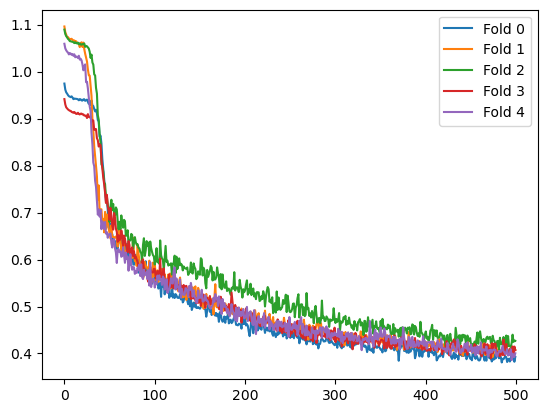

In [40]:
print(f"Avg val loss: {np.mean(list(total_val_losses.values()))}")
for fold in total_train_losses:
    plt.plot(total_train_losses[fold], label=f'Fold {fold}')
plt.legend()

Avg val KL: 0.13818026781082154


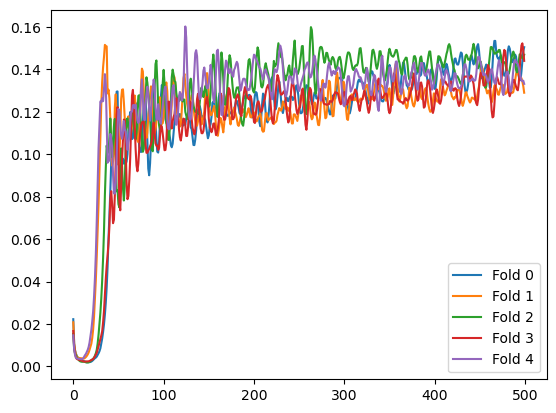

In [41]:
print(f"Avg val KL: {np.mean(list(kl_val_losses.values()))}")
for fold in kl_train_losses:
    plt.plot(kl_train_losses[fold], label=f'Fold {fold}')
plt.legend()

Avg val Recon: 0.3033019781112671


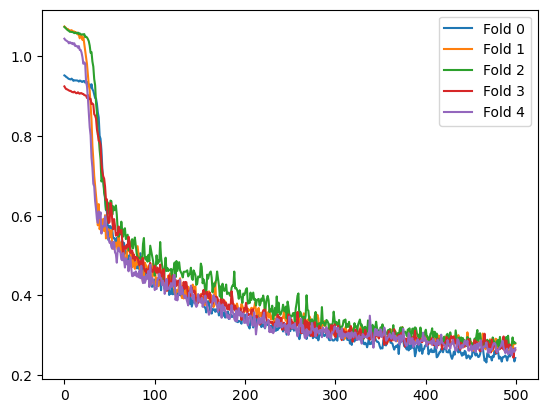

In [42]:
print(f"Avg val Recon: {np.mean(list(recon_val_losses.values()))}")
for fold in recon_train_losses:
    plt.plot(recon_train_losses[fold], label=f'Fold {fold}')
plt.legend()

In [43]:
best_model = PreFlopVAE(embedding_dim=16)
best_model.load_state_dict(best_model_state)


<All keys matched successfully>

In [44]:
best_model.eval()
with torch.no_grad():
    recon_x, mean, logvar = best_model(torch.tensor(model_data_scaled, dtype=torch.float32))
    embeddings = F.normalize(mean, p=2, dim=1)

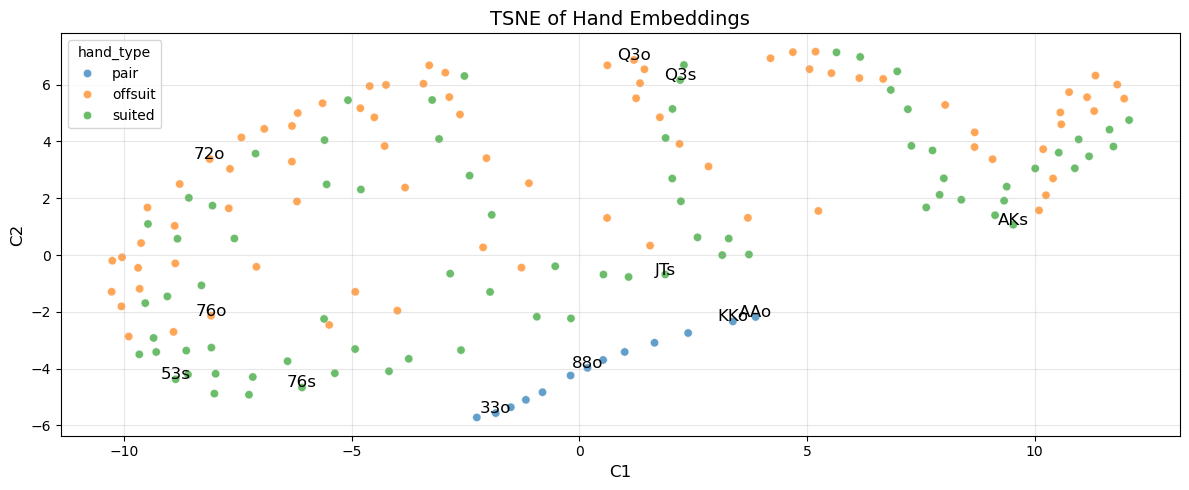

   hand         top_1         top_2         top_3       bottom_1  \
0   AAo  KKo (0.9680)  QQo (0.8657)  AKs (0.8259)  85o (-0.9068)   
1   KKo  AAo (0.9680)  QQo (0.9577)  JJo (0.8781)  62o (-0.9243)   
2   72o  84o (0.9944)  83o (0.9933)  73o (0.9932)  QQo (-0.8467)   
3   76s  86s (0.9801)  75s (0.9703)  65s (0.9670)  K8s (-0.9098)   
4   76o  84s (0.9798)  74s (0.9792)  73s (0.9775)  KJs (-0.9679)   
5   Q3s  Q2s (0.9909)  Q5o (0.9829)  Q4o (0.9801)  33o (-0.9268)   
6   Q3o  Q2o (0.9969)  Q4o (0.9948)  Q5o (0.9836)  44o (-0.9295)   
7   88o  77o (0.9920)  99o (0.9909)  TTo (0.9575)  Q2o (-0.8037)   
8   JTs  J9s (0.9750)  J8s (0.9355)  JTo (0.9280)  64o (-0.6129)   
9   33o  44o (0.9851)  22o (0.9817)  55o (0.9479)  Q3s (-0.9268)   
10  AKs  AQs (0.9905)  AKo (0.9887)  AJs (0.9760)  75o (-0.9383)   
11  53s  43s (0.9995)  64s (0.9960)  63s (0.9883)  KQs (-0.9367)   

         bottom_2       bottom_3  
0   82s (-0.9140)  83s (-0.9145)  
1   82s (-0.9264)  83s (-0.9283)  
2   AAo (-

In [45]:

similarity_df = analyze_embeddings(
    embeddings, 
    hands_of_interest=['AAo','KKo','72o','76s','76o','Q3s',"Q3o",'88o','JTs','33o',"AKs","53s"],
    hand_feature_to_color='hand_type',
    figsize=(12,5)
    )


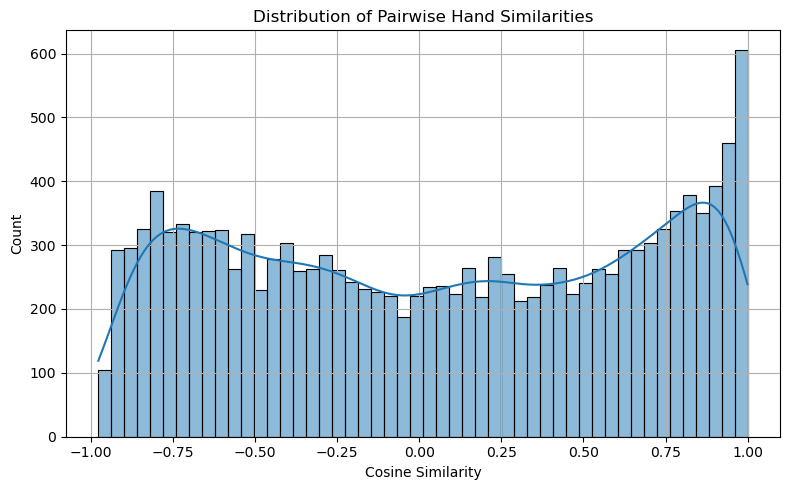

In [46]:
mask = np.triu(np.ones(similarity_df.shape), k=1).astype(bool)
pairwise_sims = similarity_df.where(mask)
all_similarities = pairwise_sims.stack().values

plt.figure(figsize=(8, 5))
sns.histplot(all_similarities, bins=50, kde=True)
plt.title("Distribution of Pairwise Hand Similarities")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
prob_data = pd.read_csv('data/processed/prob_data.csv')

In [48]:
prob_res = prob_embeddings(embeddings, prob_data)

In [49]:
prob_res[prob_res.attribute == 'suited_connector']

,attribute,class,accuracy,precision,recall,f1_score,support_frac,rmse
78,suited_connector,0,0.946746,0.945455,1.000000,0.971963,0.923077,NaN
79,suited_connector,1,0.946746,1.000000,0.307692,0.470588,0.076923,NaN


In [50]:
prob_res[prob_res.attribute =='connector']

,attribute,class,accuracy,precision,recall,f1_score,support_frac,rmse
72,connector,0,0.899408,0.920000,0.965035,0.941980,0.846154,NaN
73,connector,1,0.899408,0.736842,0.538462,0.622222,0.153846,NaN


In [51]:
prob_res[prob_res.attribute =='suited']

,attribute,class,accuracy,precision,recall,f1_score,support_frac,rmse
0,suited,0,0.899408,0.902174,0.912088,0.907104,0.538462,NaN
1,suited,1,0.899408,0.896104,0.884615,0.890323,0.461538,NaN


In [52]:
evaluate_hand_hand_equity(embeddings, equity_matrix.to_numpy())

{'spear_corr': np.float64(0.600136946782536), 'pval': np.float64(0.0)}

In [ ]:
# prob_res.to_csv("results/prob_preflop_vae16.csv", index=False)
# similarity_df.reset_index().rename({"index":'hand'},axis=1).to_csv("results/sim_preflop_vae16.csv")

In [ ]:
# save_model_and_embeddings(
#     embeddings,
#     'preflop_embeddings_vae',
#     best_model,
#     "preflop_vae_encoder_weights"
#     )